#### Neural network model

Neural network models are very popular for trying to pick up on nonlinearities that exist in data. In this notebook, we are going to use the same features we've always been using to try to predict the next day's return on the S&P 500. 
As a reminder, the features that we have are: 
* NATR 14 -> Normalized Average True Range
* MACD Histogram Normalized
* MACD Signal Normalized
* Returns over 1, 3, and 5 day periods

The type of neural network model that we will build is a simple multi layered perceptron. We are going to utilize the Tensorflow `Sequential` module to set this up. First, we will set up a simple model with mean squared error as the loss and a callback using an `EarlyStopping` callback. After that, we are going to set things up such that they can be parameterized and then we choose the parameters that give us the best performance. 

After we do all that, we are going to analyze the predictions and look at the residuals and stuff like that. 

In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf



In [4]:
data = pd.read_csv("train.csv", index_col=0)
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# Creating the training data and the validation data. 
# The data is nowhere here
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.15, shuffle = False)


#### Setting up our initial sequential model

In [13]:
base_nn_model = tf.keras.Sequential()
base_nn_model.add(tf.keras.layers.Dense(3, activation = 'relu'))
base_nn_model.add(tf.keras.layers.Dense(3, activation = 'relu'))
base_nn_model.add(tf.keras.layers.Dense(1, activation = 'linear'))

In [14]:
base_nn_model.compile(
    optimizer = tf.keras.optimizers.Adam(), 
    loss = tf.keras.losses.MeanSquaredError(), 
    metrics = ['mse', 'mae']
)

In [26]:
def create_base_nn_model(layer_1_units: int = 3, layer_2_units: int = 3, model_name: str = None) -> tf.keras.models.Model: 

    if model_name is None: 
        model_name = f'Base_NN_model_{layer_1_units}_{layer_2_units}'

    model = tf.keras.Sequential(name=model_name)
    model.add(tf.keras.layers.Dense(3, activation = 'relu'))
    model.add(tf.keras.layers.Dense(3, activation = 'relu'))
    model.add(tf.keras.layers.Dense(1, activation = 'linear'))

    model.compile(
        optimizer = tf.keras.optimizers.Adam(), 
        loss = tf.keras.losses.MeanSquaredError(), 
        metrics = ['mse', 'mae']
    )

    return model


In [15]:
EPOCHS = 100

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10
)

history = base_nn_model.fit(x = X_train, y = y_train, batch_size = 32, epochs = EPOCHS, validation_data = (X_val, y_val), callbacks=[early_stopping])

Epoch 1/100
287/287 [==============================] - 3s 6ms/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0218 - val_loss: 3.9915e-04 - val_mse: 3.9915e-04 - val_mae: 0.0112
Epoch 2/100
287/287 [==============================] - 1s 5ms/step - loss: 1.0088e-04 - mse: 1.0088e-04 - mae: 0.0070 - val_loss: 2.6959e-04 - val_mse: 2.6959e-04 - val_mae: 0.0101
Epoch 3/100
287/287 [==============================] - 1s 5ms/step - loss: 9.8815e-05 - mse: 9.8815e-05 - mae: 0.0070 - val_loss: 2.5190e-04 - val_mse: 2.5190e-04 - val_mae: 0.0099
Epoch 4/100
287/287 [==============================] - 1s 5ms/step - loss: 9.8420e-05 - mse: 9.8420e-05 - mae: 0.0070 - val_loss: 2.4437e-04 - val_mse: 2.4437e-04 - val_mae: 0.0098
Epoch 5/100
287/287 [==============================] - 1s 5ms/step - loss: 9.8169e-05 - mse: 9.8169e-05 - mae: 0.0070 - val_loss: 2.3840e-04 - val_mse: 2.3840e-04 - val_mae: 0.0098
Epoch 6/100
287/287 [==============================] - 1s 5ms/step - loss: 9.8045e-05 - mse: 9.8045e-05

We are going to look at the model predictions and compare that to what we saw with the linear regression model earlier. 

In [16]:
predictions = base_nn_model.predict(X_train)

287/287 [==============================] - 1s 3ms/step


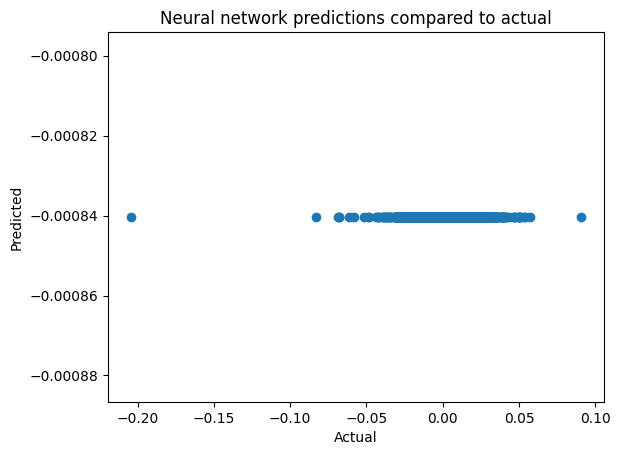

In [24]:
fig, ax = plt.subplots() 
ax.scatter(y_train, predictions)
ax.set(title = 'Neural network predictions compared to actual', xlabel = 'Actual', ylabel = 'Predicted')
plt.show()

We can see with this initial model that we have a pretty shitty model. It is predicting the same value each time no matter what happens. Why could this be happening? 
* We did not feature scale our data before putting it into the model. This could be making the weights stuck from updating to get a better loss 
* The model might not be "deep enough" and not able to pick up the real non-linearities in the data for now


In [39]:
# Standardizing before entering the model
standard_scaler = StandardScaler()
X_train_scaled = standard_scaler.fit_transform(X_train)
X_val_scaled = standard_scaler.transform(X_val)

y_train_scaled = (y_train - y_train.mean())/(y_train.std())
y_val_scaled = (y_val - y_train.mean())/(y_train.std())

model = create_base_nn_model(
    model_name = 'scaled_model', 
    layer_1_units=3, 
    layer_2_units=3
)

EPOCHS = 100
standard_model_history = model.fit(
    x = X_train_scaled, 
    y = y_train_scaled, 
    batch_size=32, 
    callbacks=[early_stopping], 
    validation_data = (X_val_scaled, y_val_scaled), 
    epochs = EPOCHS
)


Epoch 1/100


287/287 [==============================] - 3s 6ms/step - loss: 2.3500 - mse: 2.3500 - mae: 0.9690 - val_loss: 4.5641 - val_mse: 4.5641 - val_mae: 1.2341
Epoch 2/100
287/287 [==============================] - 1s 5ms/step - loss: 1.2954 - mse: 1.2954 - mae: 0.7764 - val_loss: 3.2928 - val_mse: 3.2928 - val_mae: 1.1151
Epoch 3/100
287/287 [==============================] - 2s 6ms/step - loss: 1.1330 - mse: 1.1330 - mae: 0.7437 - val_loss: 2.8988 - val_mse: 2.8988 - val_mae: 1.0682
Epoch 4/100
287/287 [==============================] - 1s 5ms/step - loss: 1.0726 - mse: 1.0726 - mae: 0.7277 - val_loss: 2.7035 - val_mse: 2.7035 - val_mae: 1.0407
Epoch 5/100
287/287 [==============================] - 1s 5ms/step - loss: 1.0421 - mse: 1.0421 - mae: 0.7176 - val_loss: 2.5916 - val_mse: 2.5916 - val_mae: 1.0243
Epoch 6/100
287/287 [==============================] - 1s 5ms/step - loss: 1.0243 - mse: 1.0243 - mae: 0.7121 - val_loss: 2.5228 - val_mse: 2.5228 - val_mae: 1.0142
Epoch 7/100
287/287 [=

287/287 [==============================] - 1s 4ms/step


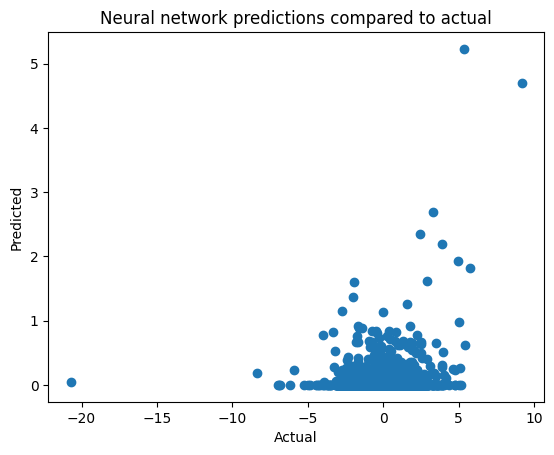

In [40]:
predictions = model.predict(X_train_scaled)
fig, ax = plt.subplots() 
ax.scatter(y_train_scaled, predictions)
ax.set(title = 'Neural network predictions compared to actual', xlabel = 'Actual', ylabel = 'Predicted')
plt.show()


We see from here that if we do the standardized scaling to the data, we don't get anything good still. This might suggest that our perceptron model is not good at all. We may need to make some enhancements to it. What things can we change? 
* The number of units in each of the Dense layers 
* Change the activation function in each of the Dense layers
* Do a different type of feature scaling for each column 
* Add more layers into each of the steps
    * Dropout layer 
    * BatchNormalization layer 

I think for our purposes, we are going to try out a different number of units in both of the layers and see what happens. 

In [43]:
different_nn_model = create_base_nn_model(
    layer_1_units=64, 
    layer_2_units=32
)

EPOCHS = 100
different_nn_model_history = different_nn_model.fit(
    x = X_train_scaled, 
    y = y_train, 
    batch_size=32, 
    callbacks=[early_stopping], 
    validation_data = (X_val_scaled, y_val), 
    epochs = EPOCHS
)

Epoch 1/100


287/287 [==============================] - 3s 6ms/step - loss: 0.4071 - mse: 0.4071 - mae: 0.3524 - val_loss: 0.0932 - val_mse: 0.0932 - val_mae: 0.1873
Epoch 2/100
287/287 [==============================] - 1s 5ms/step - loss: 0.0378 - mse: 0.0378 - mae: 0.1297 - val_loss: 0.0309 - val_mse: 0.0309 - val_mae: 0.1187
Epoch 3/100
287/287 [==============================] - 2s 5ms/step - loss: 0.0170 - mse: 0.0170 - mae: 0.0938 - val_loss: 0.0154 - val_mse: 0.0154 - val_mae: 0.0850
Epoch 4/100
287/287 [==============================] - 2s 5ms/step - loss: 0.0094 - mse: 0.0094 - mae: 0.0687 - val_loss: 0.0088 - val_mse: 0.0088 - val_mae: 0.0628
Epoch 5/100
287/287 [==============================] - 2s 5ms/step - loss: 0.0056 - mse: 0.0056 - mae: 0.0511 - val_loss: 0.0053 - val_mse: 0.0053 - val_mae: 0.0472
Epoch 6/100
287/287 [==============================] - 2s 6ms/step - loss: 0.0035 - mse: 0.0035 - mae: 0.0385 - val_loss: 0.0033 - val_mse: 0.0033 - val_mae: 0.0361
Epoch 7/100
287/287 [=

287/287 [==============================] - 1s 4ms/step


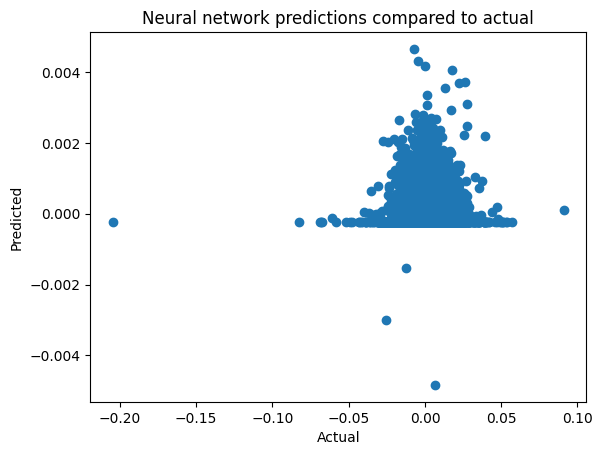

In [44]:
predictions = different_nn_model.predict(X_train_scaled)
fig, ax = plt.subplots() 
ax.scatter(y_train, predictions)
ax.set(title = 'Neural network predictions compared to actual', xlabel = 'Actual', ylabel = 'Predicted')
plt.show()

### Conclusion 

We attempted to take the same dataset using the technical features that we broke out and create a neural network model for predicting the S&P 500 return. From the initial sequential models that we've set up, not many of them look that promising for figuring out the day over day close return. We left a lot of things on the table here though to try out: 
* Varying model architectures like depth and number of nodes 
* Running a real hyper parameter optimization 
* Testing out different scaling methodologies to see if they would all work 

With neural networks, there are so many things that you can try out. You can try out different types of cells (LSTM, CNN, etc). We will get into all those soon enough. 
